## Graduation Research 

In [1]:
import tensorflow as tf
from sklearn import cross_validation
import keras.callbacks
import keras.backend.tensorflow_backend as KTF
from keras.preprocessing import image
import keras

from keras.models import load_model
import random as rn
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.models import model_from_json
from keras.applications.vgg16 import VGG16, preprocess_input 
#https://stackoverflow.com/questions/47555829/preprocess-input-method-in-keras                                                                                                            

from PIL import Image
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
#from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.svm import LinearSVC

from PIL import ImageFile
import math

/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


## MNISTのデータセットを利用して中間層出力検証方法の正確性を検証する(grad_cam検証)

In [9]:
#from sklearn.datasets import fetch_mldata
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.preprocessing.image import array_to_img, img_to_array, load_img

from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras 
import sys 
import cv2

from keras.models import load_model
# keep_dims is deprecated, use keepdims instead これに対する解決法                                  
tf.logging.set_verbosity(tf.logging.ERROR)

ImageFile.LOAD_TRUNCATED_IMAGES = True
K.set_learning_phase(1)

config = tf.ConfigProto(device_count={'GPU':1,'CPU':56})
sess = tf.Session(config=config)
keras.backend.set_session(sess)

STANDARD_SIZE = (300, 300)

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)

#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(0)

input_shape = (300, 300, 3)
batch_size = 4
epochs = 10
num_classes = 10

f_log = './logs'
f_model = './model'


model_filename = 'cnn_model.json'
weights_filename = 'cnn_model_weights.hdf5'


def input_data(path_train, path_test):

    x = []

    with open(path_train, "r") as f:
        train_path_list = f.readlines()

    filenames = []
    labels = []
    for row in train_path_list:
        row = row.split(" ")
        filenames.append(row[0])
        labels.append(row[1])

    label = []
    for i in labels:
        label.append(int(i))

    for f in filenames:
        x.append(image.img_to_array(img_to_matrix(f)))

    x = np.asarray(x)
    #正規化
    x /= 255
    y = np.asarray(label)
    y = keras.utils.to_categorical(y, num_classes)

    '==============================================================='

    a = []

    with open(path_test, "r") as f:
        train_path_list = f.readlines()

    filenames1 = []
    labels1 = []
    for row in train_path_list:
        row = row.split(" ")
        filenames1.append(row[0])
        labels1.append(row[1])

    label1 = []
    for i in labels1:
        label1.append(int(i))

    for f in filenames1:
        a.append(image.img_to_array(img_to_matrix(f)))

    test_data = np.asarray(a)
    # 正規化
    test_data /= 255
    test_label = np.asarray(label1)
    test_label = keras.utils.to_categorical(test_label, num_classes)

    train_data, valid_data, train_label, valid_label = cross_validation.train_test_split(x, y, test_size=0.3)
    test_data, valid1, test_label, valid2 = cross_validation.train_test_split(test_data, test_label, test_size=0.3)

    return train_data, test_data, train_label, test_label, valid_data, valid_label

# parse image
def img_to_matrix(filename, verbose=False):
    img = Image.open(filename)
    if verbose:
        print('changing size from %s to %s' % (str(img.size), str(STANDARD_SIZE)))
    img = img.resize(STANDARD_SIZE)

    imgArray = np.asarray(img)
    return imgArray  # imgArray.shape = (167 x 300 x 3)


# 1次元に引き延ばす(PCAで使用)
def flatten_image(img):

    s = img.shape[0] * img.shape[1] * img.shape[2]
    img_wide = img.reshape(1, s)
    return img_wide[0]


def handle_image_with_pca(intermediate_output, y_test):
    images = intermediate_output
    labels = y_test
    ls = []

    for i in labels:
        if i == 1:
            ls.append("cloudy_seesaa")
        elif i == 0:
            ls.append("sunny_seesaa")
    labels = ls

    data = []
    for image in images:
        img = flatten_image(image)
        data.append(img)

    data = np.array(data)

    is_train = np.random.uniform(0, 1, len(data)) <= 0.7
    y = np.where(np.array(labels) == 'cloudy_seesaa', 1, 0)

    train_x, train_y = data[is_train], y[is_train]

    # plot in 2 dimensions
    pca = RandomizedPCA(n_components=2)
    X = pca.fit_transform(data)
    df = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                       "label": np.where(y == 1, 'cloudy_seesaa', 'sunny_seesaa')})
    colors = ['blue', 'red']

    plt.figure(figsize=(10, 10))
    for label, color in zip(df['label'].unique(), colors):
        mask = df['label'] == label
        plt.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)
    sns.set()
    plt.xlabel("pc1 (Principal Component1)")  # 全データの分散が最大となる方向
    plt.ylabel("pc2 (Principal Component2)")  # 第一主成分に垂直な方向の軸
    plt.legend()
    #plt.show()
    plt.savefig('pca_feature1.png')

    # training a classifier
    pca = RandomizedPCA(n_components=5)
    train_x = pca.fit_transform(train_x)

    svm = LinearSVC(C=1.0)
    svm.fit(train_x, train_y)
    joblib.dump(svm, 'model.pkl')

    # evaluating the model
    test_x, test_y = data[is_train == False], y[is_train == False]
    test_x = pca.transform(test_x)
    print(pd.crosstab(test_y, svm.predict(test_x),
                      rownames=['Actual'], colnames=['Predicted']))

def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def load_image(path):
    img_path = path
    img = image.load_img(img_path, target_size=(300, 300))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='conv2d_4'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = model
    return new_model

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def grad_cam(input_model, image, category_index, layer_name):
    model = Sequential()
    model.add(input_model)

    nb_classes = 2
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    model.add(Lambda(target_layer,
                     output_shape = target_category_loss_output_shape))

    loss = K.sum(model.layers[-1].output)
    print(model.layers[0].layers[1].output)
    print(model.layers)
    print(model.layers[0])
    print(model.layers[0].layers[1].name)
    print("~~~~~~")
    print([l for l in  model.layers[0].layers if l.name == layer_name])
    # 結論 is が反応してない。おそらくpythonのversionが原因か? python3.5 6 out
    conv_output = [l for l in model.layers[0].layers if l.name == layer_name][0].output #model.layers[0].layers[1].output
    #model.get_layer(layer_name).output
    print(conv_output)
       

    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])
    print(model.layers[0].layers)
    print(model.layers)
    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (300, 300))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)
    
    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap

def Grad_Cam(input_model, x, layer_name):
    '''
    Args:
       input_model: モデルオブジェクト
       x: 画像(array)
       layer_name: 畳み込み層の名前

    Returns:
       jetcam: 影響の大きい箇所を色付けした画像(array)

    '''
 
    # 前処理
    X = np.expand_dims(x, axis=0)

    X = X.astype('float32')
    preprocessed_input = X / 255.0
 

    # 予測クラスの算出

    predictions = input_model.predict(X)
    class_idx = np.argmax(predictions[0])
    
    #class_output = input_model.output[:, class_idx]
    class_output =  K.sum(input_model.layers[-1].output)  
    print(class_output)
    
    #  勾配を取得
    conv_output = input_model.get_layer(layer_name).output   # layer_nameのレイヤーのアウトプット
    grads = K.gradients(class_output, conv_output)[0]  # gradients(loss, variables) で、variablesのlossに関しての勾配を返す
    gradient_function = K.function([input_model.input], [conv_output, grads])  # model.inputを入力すると、conv_outputとgradsを出力する関数

    output, grads_val = gradient_function([X])
    output, grads_val = output[0], grads_val[0]

     # 重みを平均化して、レイヤーのアウトプットに乗じる
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    print(cam)
    # 画像化してヒートマップにして合成

    cam = cv2.resize(cam, (300, 300), cv2.INTER_LINEAR) # 画像サイズは200で処理したので
    cam = np.maximum(cam, 0) 
    cam = cam / cam.max()

    jetcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
    jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)  # 色をRGBに変換
    jetcam = (np.float32(jetcam) + X / 2)   # もとの画像に合成

    return jetcam



def main():
    
    x_train, x_test, y_train, y_test, valid_data, valid_label = input_data("path_and_label_train.txt",
                                                                           "path_and_label_test.txt")

    """
    mnist = fetch_mldata('MNIST original', data_home="./data_home")
    
    x = mnist.data
    y = mnist.target
    y = keras.utils.to_categorical(y, num_classes)
    
    
    x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.3)

    
    old_session = KTF.get_session()

    with tf.Graph().as_default():

        session = tf.Session('')
        KTF.set_session(session)
        KTF.set_learning_phase(1)

        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3, 3),
                         activation='relu',
                         input_shape=input_shape, kernel_initializer="he_normal",
                         bias_initializer="zeros"))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(28, activation='relu', init="he_uniform"))
        model.add(Dropout(0.5))
        model.add(Dense(num_classes, activation='softmax')) # num_classes = 9値分類


    """

    # load trained model
    #json_string = open(os.path.join(f_model, model_filename)).read()
    #model = model_from_json(json_string)
    #model.load_weights(os.path.join(f_model, weights_filename))
    model = load_model("./model/Mymodel.h5")
    print(model.summary())

    """
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer="SGD",
                      metrics=['accuracy'])

        print(model.summary())

        # callback function
        tb_cb = keras.callbacks.TensorBoard(log_dir=f_log, histogram_freq=1)
        cbks = [tb_cb]

        # train
        history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,       #進行状況の表示モード
                            callbacks=cbks,  # [plot_losses, csv_logger],
                            validation_data=(x_test, y_test))
        score_train = model.evaluate(x_train,y_train, verbose=1, batch_size=4) 
        score_test = model.evaluate(x_test, y_test, verbose=1, batch_size=4)
        print('Train loss: {0}'.format(score_train[0]))
        print('Train accuracy: {0}'.format(score_train[1]))
        print('Test loss: {0}'.format(score_test[0]))
        print('Test accuracy: {0}'.format(score_test[1]))
        
        # 学習済みモデル書き出し
        json_string = model.to_json()
        open(os.path.join(f_model, 'cnn_model.json'), 'w').write(json_string)
        yaml_string = model.to_yaml()
        open(os.path.join(f_model, 'cnn_model.yaml'), 'w').write(yaml_string)
        print('save weights')
        model.save_weights(os.path.join(f_model, 'cnn_model_weights.hdf5'))

        # modelのlayer_nameを調べる
        for layer in model.layers:
            print(layer.name)
            
        layer_name ="conv2d_2"#"dropout_1"#"conv2d_2"# "max_pooling2d_1"
        intermediate_layer_model = keras.models.Model(inputs=model.input,
                                                      outputs=model.get_layer(layer_name).output)
       
        layers = model.layers[1:2]#[3:4]#[1:2]#[2:3]
        img = image.load_img("/home/seimei/Graduation_Research/dataset_valid/hare/class3-1/image_0064.jpg", target_size=(300, 300))
        img = image.img_to_array(img)
        img /= 255
        img = np.expand_dims(img, axis=0)
        # 指定したlayer_nameと一致するレイヤーの出力を取得する
        activations = intermediate_layer_model.predict(img)
        activations = [activation for layer, activation in zip(layers, activations) if isinstance(layer, Conv2D)]
        print(activations)
        # 単品の特徴画像生成#
        for i, activation in enumerate(activations):
            num_of_image = activation.shape[2]
            max = np.max(activation[0])
            for j in range(0, num_of_image):
                plt.figure(figsize=(50, 50))
                sns.heatmap(activation[:, :,j], vmin=0, vmax=max, xticklabels=False, yticklabels=False, square=False)
                plt.savefig("%d_%d.png" % (i+1, j+1))
                plt.close()
        # 出力層ごとに特徴画像を並べてヒートマップ画像として出力
        for i, activation in enumerate(activations):
            num_of_image = activation.shape[2]
            cols = math.ceil(math.sqrt(num_of_image))
            rows = math.floor(num_of_image / cols)
            screen = []
            for y in range(0, rows):
                row = []
                for x in range(0, cols):
                    j = y * cols + x
                    if j < num_of_image:
                        row.append(activation[:, :, j])
                    else:
                        row.append(np.zeros())
                screen.append(np.concatenate(row, axis=1))
            screen = np.concatenate(screen, axis=0)
            plt.figure(figsize=(50, 50))
            sns.heatmap(screen, xticklabels=False, yticklabels=False)
            name = "maxpooling2d"
            plt.savefig("%s.png" % name)
            plt.close()
        """
    img = image.load_img("/home/seimei/Graduation_Research/dataset_valid/hare/class3-1/image_0001.jpg", target_size=(300, 300))
    img = image.img_to_array(img)
    #img.astype('float32')
    img /= 255.0

    preprocessed_input = load_image("/home/seimei/Graduation_Research/dataset_valid/hare/class3-1/image_0001.jpg")
    predictions=model.predict(np.expand_dims(img, axis=0))
    predicted_class= np.argmax(predictions)
    #print(predicted_class)
    #print(predictions)
    
    imag = Grad_Cam(model, img, 'conv2d_4')
    print(imag)
    image1=image.array_to_img(np.squeeze(imag, axis=0))
    print(image1)
    #cv2.imshow("image", image1)
    image1.save("./image.jpg")
    #cv2.imwrite('image.jpg',image1)
    
    cam, heatmap = grad_cam(model, np.expand_dims(img, axis=0), predicted_class, "conv2d_4")
    cv2.imwrite("gradcam.jpg", cam)

    register_gradient()
    guided_model = modify_backprop(model, 'GuidedBackProp')
    saliency_fn = compile_saliency_function(guided_model)
    saliency = saliency_fn([preprocessed_input, 0])
    gradcam = saliency[0] * heatmap[..., np.newaxis]
    cv2.imwrite("guided_gradcam.jpg", deprocess_image(gradcam))
        #handle_image_with_pca(activations, np.zeros(1))
    #KTF.set_session(old_session)# add for TeonsorBoard
    
if __name__ == '__main__':
    main()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 300, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 300, 300, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 64)        0         
__________

/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/ipykernel_launcher.py:350: RuntimeWarning: invalid value encountered in true_divide


Tensor("conv2d_2_6/Relu:0", shape=(?, 300, 300, 32), dtype=float32)
[<keras.models.Sequential object at 0x7f547644fa20>, <keras.layers.core.Lambda object at 0x7f5475926b38>]
conv2d_2
~~~~~~
Tensor("conv2d_4_6/Relu:0", shape=(?, 150, 150, 64), dtype=float32)
[<keras.layers.convolutional.Conv2D object at 0x7f547644fa58>, <keras.layers.convolutional.Conv2D object at 0x7f547642b128>, <keras.layers.pooling.MaxPooling2D object at 0x7f547642beb8>, <keras.layers.core.Dropout object at 0x7f5476892ef0>, <keras.layers.convolutional.Conv2D object at 0x7f5476440c18>, <keras.layers.convolutional.Conv2D object at 0x7f547645ad68>, <keras.layers.pooling.MaxPooling2D object at 0x7f547642b0b8>, <keras.layers.core.Flatten object at 0x7f547645ab00>, <keras.layers.core.Dense object at 0x7f5475992da0>, <keras.layers.core.Dropout object at 0x7f54759ad6a0>, <keras.layers.core.Dense object at 0x7f54759ada20>]
[<keras.models.Sequential object at 0x7f547644fa20>, <keras.layers.core.Lambda object at 0x7f5475926b38

TypeError: Cannot interpret feed_dict key as Tensor: Can not convert a int into a Tensor.

## 1枚の画像に対しPCA

In [ ]:

ImageFile.LOAD_TRUNCATED_IMAGES = True

config = tf.ConfigProto(device_count={'GPU':1,'CPU':56})
sess = tf.Session(config=config)
keras.backend.set_session(sess)

STANDARD_SIZE = (36, 36)

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)

#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(0)

input_shape = (36, 36, 3)
batch_size = 4
epochs = 30
num_classes = 2

f_log = './logs'
f_model = './model'


model_filename = 'cnn_model.json'
weights_filename = 'cnn_model_weights.hdf5'


def input_data(path_train, path_test):

    x = []

    with open(path_train, "r") as f:
        train_path_list = f.readlines()

    filenames = []
    labels = []
    for row in train_path_list:
        row = row.split(" ")
        filenames.append(row[0])
        labels.append(row[1])

    label = []
    for i in labels:
        label.append(int(i))

    for f in filenames:
        x.append(image.img_to_array(img_to_matrix(f)))

    x = np.asarray(x)
    #正規化
    x /= 255
    y = np.asarray(label)
    y = keras.utils.to_categorical(y, num_classes)

    '==============================================================='

    a = []

    with open(path_test, "r") as f:
        train_path_list = f.readlines()

    filenames1 = []
    labels1 = []
    for row in train_path_list:
        row = row.split(" ")
        filenames1.append(row[0])
        labels1.append(row[1])

    label1 = []
    for i in labels1:
        label1.append(int(i))

    for f in filenames1:
        a.append(image.img_to_array(img_to_matrix(f)))

    test_data = np.asarray(a)
    # 正規化
    test_data /= 255
    test_label = np.asarray(label1)
    test_label = keras.utils.to_categorical(test_label, num_classes)

    train_data, valid_data, train_label, valid_label = cross_validation.train_test_split(x, y, test_size=0.3)
    test_data, valid1, test_label, valid2 = cross_validation.train_test_split(test_data, test_label, test_size=0.3)

    return train_data, test_data, train_label, test_label, valid_data, valid_label



# parse image
def img_to_matrix(filename, verbose=False):
    img = Image.open(filename)
    if verbose:
        print('changing size from %s to %s' % (str(img.size), str(STANDARD_SIZE)))
    img = img.resize(STANDARD_SIZE)

    imgArray = np.asarray(img)
    return imgArray  # imgArray.shape = (167 x 300 x 3)


# 1次元に引き延ばす(PCAで使用)
def flatten_image(img):

    s = img.shape[0] * img.shape[1] * img.shape[2]
    img_wide = img.reshape(1, s)
    return img_wide[0]


def handle_image_with_pca(intermediate_output, y_test):
    images = intermediate_output
    labels = y_test
    ls = []

    for i in labels:
        if i == 1:
            ls.append("cloudy_seesaa")
        elif i == 0:
            ls.append("sunny_seesaa")
    labels = ls

    data = []
    for image in images:
        img = flatten_image(image)
        data.append(img)

    data = np.array(data)

    is_train = np.random.uniform(0, 1, len(data)) <= 0.7
    y = np.where(np.array(labels) == 'cloudy_seesaa', 1, 0)

    train_x, train_y = data[is_train], y[is_train]

    # plot in 2 dimensions
    pca = RandomizedPCA(n_components=2)
    X = pca.fit_transform(data)
    df = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                       "label": np.where(y == 1, 'cloudy_seesaa', 'sunny_seesaa')})
    colors = ['blue', 'red']

    plt.figure(figsize=(10, 10))
    for label, color in zip(df['label'].unique(), colors):
        mask = df['label'] == label
        plt.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)
    sns.set()
    plt.xlabel("pc1 (Principal Component1)")  # 全データの分散が最大となる方向
    plt.ylabel("pc2 (Principal Component2)")  # 第一主成分に垂直な方向の軸
    plt.legend()
    #plt.show()
    plt.savefig('pca_feature1.png')

    # training a classifier
    pca = RandomizedPCA(n_components=5)
    train_x = pca.fit_transform(train_x)

    svm = LinearSVC(C=1.0)
    svm.fit(train_x, train_y)
    joblib.dump(svm, 'model.pkl')

    # evaluating the model
    test_x, test_y = data[is_train == False], y[is_train == False]
    test_x = pca.transform(test_x)
    print(pd.crosstab(test_y, svm.predict(test_x),
                      rownames=['Actual'], colnames=['Predicted']))


def main():

    x_train, x_test, y_train, y_test, valid_data, valid_label = input_data("path_and_label_train.txt",
                                                                           "path_and_label_test.txt")

    old_session = KTF.get_session()

    with tf.Graph().as_default():

        session = tf.Session('')
        KTF.set_session(session)
        KTF.set_learning_phase(1)
        """
        model = Sequential()
        model.add(Conv2D(64, kernel_size=(3, 3),
                         activation='relu',
                         input_shape=input_shape, kernel_initializer="he_normal",
                         bias_initializer="zeros",
                        padding='same', name='block1_conv1'))
        model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'))
        model.add(MaxPooling2D(pool_size=(2, 2),padding='same', name='block1_pool'))
        model.add(Conv2D(128,(3,3), activation='relu',padding='same', name='block2_conv1'))
        model.add(Conv2D(128,(3,3), activation='relu',padding='same', name='block2_conv2'))
        model.add(MaxPooling2D(pool_size=(2,2),padding='same', name='block2_pool'))        
        model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'))
        model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'))
        model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block3_pool'))
        model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'))
        model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'))
        model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block4_pool'))
        model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'))
        model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'))
        model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block5_pool'))

        model.add(Flatten())
        model.add(Dense(4096, activation='relu', name='fc1'))
        model.add(Dropout(0.5, name='dropout1'))

        model.add(Dense(4096, activation='relu',name='fc2' ))
        model.add(Dropout(0.5, name='dropout2'))
        model.add(Dense(num_classes, activation='softmax')) # num_classes = 2値分類

        """
        # load trained model
        json_string = open(os.path.join(f_model, model_filename)).read()
        model = model_from_json(json_string)
        model.load_weights(os.path.join(f_model, weights_filename))
        """
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer="SGD",
                      metrics=['accuracy'])

        print(model.summary())

        # callback function
        tb_cb = keras.callbacks.TensorBoard(log_dir=f_log, histogram_freq=1)
        cbks = [tb_cb]

        # train
        history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,       #進行状況の表示モード
                            callbacks=cbks,  # [plot_losses, csv_logger],
                            validation_data=(x_test, y_test))
        score_train = model.evaluate(x_train,y_train, verbose=1, batch_size=4) 
        score_test = model.evaluate(x_test, y_test, verbose=1, batch_size=4)
        print('Train loss: {0}'.format(score_train[0]))
        print('Train accuracy: {0}'.format(score_train[1]))
        print('Test loss: {0}'.format(score_test[0]))
        print('Test accuracy: {0}'.format(score_test[1]))
        
        # 学習済みモデル書き出し
        json_string = model.to_json()
        open(os.path.join(f_model, 'cnn_model.json'), 'w').write(json_string)
        yaml_string = model.to_yaml()
        open(os.path.join(f_model, 'cnn_model.yaml'), 'w').write(yaml_string)
        print('save weights')
        model.save_weights(os.path.join(f_model, 'cnn_model_weights.hdf5'))
        """
        # modelのlayer_nameを調べる
        for layer in model.layers:
            print(layer.name)

        layer_name ="block5_conv3"#"dropout_1"#"conv2d_2"# "max_pooling2d_1"
        intermediate_layer_model = keras.models.Model(inputs=model.input,
                                                      outputs=model.get_layer(layer_name).output)
       
        layers = model.layers[16:17]#[3:4]#[1:2]#[2:3]
        img = image.load_img("/home/seimei/Graduation_Research/dataset_valid/hare/class3-1/image_0064.jpg", target_size=(36, 36))
        img = image.img_to_array(img)
        img /= 255
        img = np.expand_dims(img, axis=0)
        # 指定したlayer_nameと一致するレイヤーの出力を取得する
        activations = intermediate_layer_model.predict(img)
        activations = [activation for layer, activation in zip(layers, activations) if isinstance(layer, Conv2D)]
        print(activations)
        # 単品の特徴画像生成#
        """
        for i, activation in enumerate(activations):
            num_of_image = activation.shape[2]
            max = np.max(activation[0])
            for j in range(0, num_of_image):
                plt.figure(figsize=(50, 50))
                sns.heatmap(activation[:, :,j], vmin=0, vmax=max, xticklabels=False, yticklabels=False, square=False)
                plt.savefig("%d_%d.png" % (i+1, j+1))
                plt.close()
        """
        # 出力層ごとに特徴画像を並べてヒートマップ画像として出力
        for i, activation in enumerate(activations):
            num_of_image = activation.shape[2]
            cols = math.ceil(math.sqrt(num_of_image))
            rows = math.floor(num_of_image / cols)
            screen = []
            for y in range(0, rows):
                row = []
                for x in range(0, cols):
                    j = y * cols + x
                    if j < num_of_image:
                        row.append(activation[:, :, j])
                    else:
                        row.append(np.zeros())
                screen.append(np.concatenate(row, axis=1))
            screen = np.concatenate(screen, axis=0)
            plt.figure(figsize=(50, 50))
            sns.heatmap(screen, xticklabels=False, yticklabels=False)
            name = "maxpooling2d"
            plt.savefig("%s.png" % name)
            plt.close()
        y = keras.utils.to_categorical(np.r_[np.zeros(512), np.ones(512)], num_classes)
        handle_image_with_pca(activations, y)#np.zeros(1))
    # add for TeonsorBoard

    KTF.set_session(old_session)
    
if __name__ == '__main__':
    main()

## 2枚の画像に対しPCA

## Conv2D_1

In [2]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

config = tf.ConfigProto(device_count={'GPU':1,'CPU':56})
sess = tf.Session(config=config)
keras.backend.set_session(sess)

STANDARD_SIZE = (300, 300)

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)

#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)                              
tf.set_random_seed(0)

input_shape = (300, 300, 3)
batch_size = 4
epochs = 20
num_classes = 2

f_log = './logs'
f_model = './model'


model_filename = 'cnn_model.json'
weights_filename = 'cnn_model_weights.hdf5'

def input_data(path_train, path_test):

    x = []

    with open(path_train, "r") as f:
        train_path_list = f.readlines()

    filenames = []
    labels = []
    for row in train_path_list:
        row = row.split(" ")
        filenames.append(row[0])
        labels.append(row[1])

    label = []
    for i in labels:
        label.append(int(i))

    for f in filenames:
        x.append(image.img_to_array(img_to_matrix(f)))

    x = np.asarray(x)
    #正規化                                                                                                                 
    x /= 255
    y = np.asarray(label)
    y = keras.utils.to_categorical(y, num_classes)

    '==============================================================='

    a = []
    
    with open(path_test, "r") as f:
        train_path_list = f.readlines()

    filenames1 = []
    labels1 = []
    for row in train_path_list:
        row = row.split(" ")
        filenames1.append(row[0])
        labels1.append(row[1])

    label1 = []
    for i in labels1:
        label1.append(int(i))

    for f in filenames1:
        a.append(image.img_to_array(img_to_matrix(f)))

    test_data = np.asarray(a)
    # 正規化                                                                                                                
    test_data /= 255
    test_label = np.asarray(label1)
    test_label = keras.utils.to_categorical(test_label, num_classes)

    train_data, valid_data, train_label, valid_label = cross_validation.train_test_split(x, y, test_size=0.3)
    test_data, valid1, test_label, valid2 = cross_validation.train_test_split(test_data, test_label, test_size=0.3)
    
    print(np.shape(train_data))
    print(np.shape(train_label))
    return train_data, test_data, train_label, test_label, valid_data, valid_label



# parse image                                                                                                               
def img_to_matrix(filename, verbose=False):
    img = Image.open(filename)
    if verbose:
        print('changing size from %s to %s' % (str(img.size), str(STANDARD_SIZE)))
    img = img.resize(STANDARD_SIZE)
    imgArray = np.asarray(img)
    return imgArray  # imgArray.shape = (167 x 300 x 3)                                                                     


# 1次元に引き延ばす(PCAで使用)                                                                                              
def flatten_image(img):

    s = img.shape[0] * img.shape[1] #* img.shape[2]
    img_wide = img.reshape(1, s)
    return img_wide[0]


def handle_image_with_pca(activations, y_test):

    for i in range(2):
        images = activations[i,:,:,:]
        print(images)
        if i == 0:
            labels = y_test[:64]
        elif i == 1:
            labels = y_test[64:]
        ls = []

        for label in labels:

            if list(label) == [0,1]:
                ls.append("cloudy_seesaa")
            elif list(label) == [1,0]:
                ls.append("sunny_seesaa")
        labels = ls
        print(labels)
        data = []
        for a in range(64):#for image in images:
            img = flatten_image(images[:, :, a])
            data.append(img)

        data = np.array(data)

        is_train = np.random.uniform(0, 1, len(data)) <= 0.7
        y = np.where(np.array(labels) == 'cloudy_seesaa', 1, 0)

        train_x, train_y = data[is_train], y[is_train]

        pca = PCA(n_components=2)
        X = pca.fit_transform(data)
        if i == 0:
            df1 = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                               "label": np.where(y == 1, 'cloudy_seesaa', 'sunny_seesaa')})
        elif i == 1:
            df2 = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                               "label": np.where(y == 1, 'cloudy_seesaa', 'sunny_seesaa')})
            df = pd.concat([df1, df2])
    colors = ['red','blue']

    plt.figure(figsize=(10, 10))
    for label, color in zip(df['label'].unique(), colors):
        mask = df['label'] == label
        plt.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)
    sns.set()
    plt.xlabel("pc1 (Principal Component1)")  # 全データの分散が最大となる方向                                              
    plt.ylabel("pc2 (Principal Component2)")  # 第一主成分に垂直な方向の軸                                                  
    plt.legend()
    #plt.show()                                                                                                             
    plt.savefig('pca_feature1.png')

    # training a classifier                                                                                                 
    pca =PCA(n_components=2)
    train_x = pca.fit_transform(train_x)
    """
    svm = LinearSVC(C=1.0)
    svm.fit(train_x, train_y)
    joblib.dump(svm, 'model.pkl')

    # evaluating the model                                                                                                  
    test_x, test_y = data[is_train == False], y[is_train == False]
    test_x = pca.transform(test_x)
    print(pd.crosstab(test_y, svm.predict(test_x),
                      rownames=['Actual'], colnames=['Predicted']))
    """
def main():

    x_train, x_test, y_train, y_test, valid_data, valid_label = input_data("path_and_label_train.txt",
                                                                           "path_and_label_test.txt")

    old_session = KTF.get_session()

    with tf.Graph().as_default():

        session = tf.Session('')
        KTF.set_session(session)
        KTF.set_learning_phase(1)

        model = Sequential()                                                                                                
        model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape, kernel_initializer="he_normal", bias_initializer="zeros"))                                                                         
        model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))                                                                    
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
        model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
        model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        
    
        model.add(Flatten())                                                                                                
        model.add(Dense(512, activation='relu', init='he_uniform'))                                                          
        model.add(Dropout(0.5))                                                                                             
        model.add(Dense(num_classes, activation='softmax')) # num_classes = 2値分類                                         
                                                                                                                            
                                                                                                                            
        """
       # load trained model                                                                                                
        #json_string = open(os.path.join(f_model, model_filename)).read()
        #model = model_from_json(json_string)
        #model.load_weights(os.path.join(f_model, weights_filename))
        model = load_model('./model/Mymodel2.h5')
        """                                                                                                                 
        model.compile(loss=keras.losses.categorical_crossentropy,                                                           
                      optimizer="SGD",                                                                                      
                      metrics=['accuracy'])                                                                                 
                                                                                                                            
        print(model.summary())                                                                                              
                                                                                                                            
        # callback function                                                                                                 
        tb_cb = keras.callbacks.TensorBoard(log_dir=f_log, histogram_freq=1)                                                
        cbks = [tb_cb]                                                                                                      
                                                                                                                            
        # train                                                                                                             
        history = model.fit(x_train, y_train,                                                                               
                            batch_size=batch_size,                                                                          
                            epochs=epochs,                                                                                  
                            verbose=1,       #進行状況の表示モード                                                          
                            callbacks=cbks,  # [plot_losses, csv_logger],                                                   
                            validation_data=(x_test, y_test))                                                               
        score_train = model.evaluate(x_train,y_train, verbose=1, batch_size=4)                                              
        score_test = model.evaluate(x_test, y_test, verbose=1, batch_size=4)                                                
        print('Train loss: {0}'.format(score_train[0]))                                                                     
        print('Train accuracy: {0}'.format(score_train[1]))                                                                 
        print('Test loss: {0}'.format(score_test[0]))                                                                       
        print('Test accuracy: {0}'.format(score_test[1]))                                                                   

        model.save('./model/Mymodel2.h5')
        """
        # 学習済みモデル書き出し                                                                                            
        json_string = model.to_json()                                                                                       
        open(os.path.join(f_model, 'cnn_model.json'), 'w').write(json_string)                                               
        yaml_string = model.to_yaml()                                                                                       
        open(os.path.join(f_model, 'cnn_model.yaml'), 'w').write(yaml_string)                                               
        print('save weights')                                                                                               
        model.save_weights(os.path.join(f_model, 'cnn_model_weights.hdf5'))                                                 
        """
       # modelのlayer_nameを調べる                                                                                                                         
        for layer in model.layers:
            print(layer.name)

        layer_name ="conv2d_4"# "max_pooling2d_1"                                                                                    
        intermediate_layer_model = keras.models.Model(inputs=model.input,
                                         outputs=model.get_layer(layer_name).output)


        layers = model.layers[6:7]     
        
        urls = ["/home/seimei/Graduation_Research/dataset_valid/hare/class3-1/image_0104.jpg", 
        "/home/seimei/Graduation_Research/dataset_valid/kumori/class4-5/image_0064.jpg"]

        activations = np.zeros((0,75,75,128))
        for url in urls:
            img = image.load_img(url, target_size=(300, 300))
            img = image.img_to_array(img)
            img /= 255
            img = np.expand_dims(img, axis=0)
            # 指定したlayer_nameと一致するレイヤーの出力を取得する                                                                                              
            _activations = intermediate_layer_model.predict(img)
            _activations = [activation for layer, activation in zip(layers, _activations) if isinstance(layer, Conv2D)]
            print(np.shape(_activations))
            activations = np.r_[activations, np.reshape(_activations,(-1,75,75,128))]
        print(np.shape(activations))
        """
        # 単品の特徴画像生成#                                                                                                                               
        for i, activation in enumerate(activations):
            num_of_image = activation.shape[2]
            max = np.max(activation[0])
            for j in range(0, num_of_image):
                plt.figure(figsize=(50, 50))
                sns.heatmap(activation[:, :,j], vmin=0, vmax=max, xticklabels=False, yticklabels=False, square=False)
                plt.savefig("%d_%d.png" % (i+1, j+1))
                plt.close()
        """
        # 出力層ごとに特徴画像を並べてヒートマップ画像として出力                                                                                            
        for i, activation in enumerate(activations):
            num_of_image = activation.shape[2]
            cols = math.ceil(math.sqrt(num_of_image))
            rows = math.floor(num_of_image / cols)
            screen = []
            for y in range(0, rows):
                row = []
                for x in range(0, cols):
                    j = y * cols + x
                    if j < num_of_image:
                        row.append(activation[:, :, j])
                    else:
                        row.append(np.zeros())
                screen.append(np.concatenate(row, axis=1))
            screen = np.concatenate(screen, axis=0)
            plt.figure(figsize=(50, 50))
            sns.heatmap(screen, xticklabels=False, yticklabels=False)
            name = "maxpooling2d"
            plt.savefig("%s.png" % name)
            plt.close()
        
        y = keras.utils.to_categorical(np.r_[np.zeros(128), np.ones(128)], num_classes)

        handle_image_with_pca(activations, y )
        



    # add for TeonsorBoard                                                                                                                                  

    KTF.set_session(old_session)

if __name__ == '__main__':
    main()

(388, 300, 300, 3)
(388, 2)
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/ipykernel_launcher.py:203: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="he_uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 300, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 300, 300, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 64)        0         
__________

KeyboardInterrupt: 

## Conv2D_2

(388, 300, 300, 3)
(388, 2)
conv2d_1
conv2d_2
max_pooling2d_1
dropout_1
flatten_1
dense_1
dropout_2
dense_2
(1, 296, 296, 64)
(1, 296, 296, 64)
(2, 296, 296, 64)
[[[0.         0.07439406 0.         ... 0.         0.         0.        ]
  [0.         0.07530671 0.         ... 0.         0.03418977 0.        ]
  [0.         0.01515675 0.         ... 0.         0.00278381 0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.00895094 0.04726045 0.         ... 0.         0.         0.        ]
  [0.00401854 0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.     

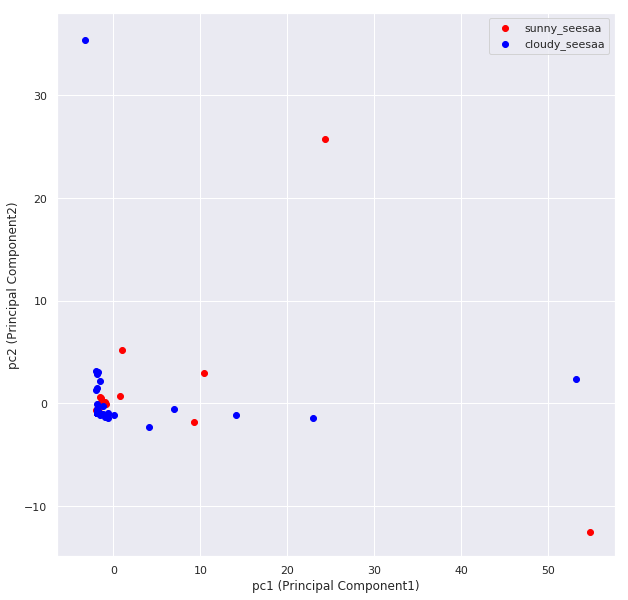

In [8]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

config = tf.ConfigProto(device_count={'GPU':1,'CPU':56})
sess = tf.Session(config=config)
keras.backend.set_session(sess)

STANDARD_SIZE = (300, 300)

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)

#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)                              
tf.set_random_seed(0)

input_shape = (300, 300, 3)
batch_size = 4
epochs = 10
num_classes = 2

f_log = './logs'
f_model = './model'


model_filename = 'cnn_model.json'
weights_filename = 'cnn_model_weights.hdf5'

def input_data(path_train, path_test):

    x = []

    with open(path_train, "r") as f:
        train_path_list = f.readlines()

    filenames = []
    labels = []
    for row in train_path_list:
        row = row.split(" ")
        filenames.append(row[0])
        labels.append(row[1])

    label = []
    for i in labels:
        label.append(int(i))

    for f in filenames:
        x.append(image.img_to_array(img_to_matrix(f)))

    x = np.asarray(x)
    #正規化                                                                                                                 
    x /= 255
    y = np.asarray(label)
    y = keras.utils.to_categorical(y, num_classes)

    '==============================================================='

    a = []
    
    with open(path_test, "r") as f:
        train_path_list = f.readlines()

    filenames1 = []
    labels1 = []
    for row in train_path_list:
        row = row.split(" ")
        filenames1.append(row[0])
        labels1.append(row[1])

    label1 = []
    for i in labels1:
        label1.append(int(i))

    for f in filenames1:
        a.append(image.img_to_array(img_to_matrix(f)))

    test_data = np.asarray(a)
    # 正規化                                                                                                                
    test_data /= 255
    test_label = np.asarray(label1)
    test_label = keras.utils.to_categorical(test_label, num_classes)

    train_data, valid_data, train_label, valid_label = cross_validation.train_test_split(x, y, test_size=0.3)
    test_data, valid1, test_label, valid2 = cross_validation.train_test_split(test_data, test_label, test_size=0.3)
    
    print(np.shape(train_data))
    print(np.shape(train_label))
    return train_data, test_data, train_label, test_label, valid_data, valid_label



# parse image                                                                                                               
def img_to_matrix(filename, verbose=False):
    img = Image.open(filename)
    if verbose:
        print('changing size from %s to %s' % (str(img.size), str(STANDARD_SIZE)))
    img = img.resize(STANDARD_SIZE)
    imgArray = np.asarray(img)
    return imgArray  # imgArray.shape = (167 x 300 x 3)                                                                     


# 1次元に引き延ばす(PCAで使用)                                                                                              
def flatten_image(img):

    s = img.shape[0] * img.shape[1] #* img.shape[2]
    img_wide = img.reshape(1, s)
    return img_wide[0]


def handle_image_with_pca(activations, y_test):

    for i in range(2):
        images = activations[i,:,:,:]
        print(images)
        if i == 0:
            labels = y_test[:64]
        elif i == 1:
            labels = y_test[64:]
        ls = []

        for label in labels:

            if list(label) == [0,1]:
                ls.append("cloudy_seesaa")
            elif list(label) == [1,0]:
                ls.append("sunny_seesaa")
        labels = ls
        print(labels)
        data = []
        for a in range(64):#for image in images:
            img = flatten_image(images[:, :, a])
            data.append(img)

        data = np.array(data)

        is_train = np.random.uniform(0, 1, len(data)) <= 0.7
        y = np.where(np.array(labels) == 'cloudy_seesaa', 1, 0)

        train_x, train_y = data[is_train], y[is_train]

        pca = PCA(n_components=2)
        X = pca.fit_transform(data)
        if i == 0:
            df1 = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                               "label": np.where(y == 1, 'cloudy_seesaa', 'sunny_seesaa')})
        elif i == 1:
            df2 = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                               "label": np.where(y == 1, 'cloudy_seesaa', 'sunny_seesaa')})
            df = pd.concat([df1, df2])
    colors = ['red','blue']

    plt.figure(figsize=(10, 10))
    for label, color in zip(df['label'].unique(), colors):
        mask = df['label'] == label
        plt.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)
    sns.set()
    plt.xlabel("pc1 (Principal Component1)")  # 全データの分散が最大となる方向                                              
    plt.ylabel("pc2 (Principal Component2)")  # 第一主成分に垂直な方向の軸                                                  
    plt.legend()
    #plt.show()                                                                                                             
    plt.savefig('pca_feature1.png')

    # training a classifier                                                                                                 
    pca = PCA(n_components=2)
    train_x = pca.fit_transform(train_x)
    """
    svm = LinearSVC(C=1.0)
    svm.fit(train_x, train_y)
    joblib.dump(svm, 'model.pkl')

    # evaluating the model                                                                                                  
    test_x, test_y = data[is_train == False], y[is_train == False]
    test_x = pca.transform(test_x)
    print(pd.crosstab(test_y, svm.predict(test_x),
                      rownames=['Actual'], colnames=['Predicted']))
    """
def main():

    x_train, x_test, y_train, y_test, valid_data, valid_label = input_data("path_and_label_train.txt",
                                                                           "path_and_label_test.txt")

    old_session = KTF.get_session()

    with tf.Graph().as_default():

        session = tf.Session('')
        KTF.set_session(session)
        KTF.set_learning_phase(1)
        """
        model = Sequential()                                                                                                
        model.add(Conv2D(32, kernel_size=(3, 3),                                                                            
                         activation='relu',                                                                                 
                         input_shape=input_shape, kernel_initializer="he_normal",                        
                         bias_initializer="zeros"))                                                                         
        model.add(Conv2D(64, (3, 3), activation='relu'))                                                                    
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))                                                                                            
        model.add(Flatten())                                                                                                
        model.add(Dense(28, activation='relu', init='he_uniform'))                                                          
        model.add(Dropout(0.5))                                                                                             
        model.add(Dense(num_classes, activation='softmax')) # num_classes = 2値分類                                         
                                                                                                                            
                                                                                                                            
        """
       # load trained model                                                                                                
        json_string = open(os.path.join(f_model, model_filename)).read()
        model = model_from_json(json_string)
        model.load_weights(os.path.join(f_model, weights_filename))
        """                                                                                                                 
        model.compile(loss=keras.losses.categorical_crossentropy,                                                           
                      optimizer="SGD",                                                                                      
                      metrics=['accuracy'])                                                                                 
                                                                                                                            
        print(model.summary())                                                                                              
                                                                                                                            
        # callback function                                                                                                 
        tb_cb = keras.callbacks.TensorBoard(log_dir=f_log, histogram_freq=1)                                                
        cbks = [tb_cb]                                                                                                      
                                                                                                                            
        # train                                                                                                             
        history = model.fit(x_train, y_train,                                                                               
                            batch_size=batch_size,                                                                          
                            epochs=epochs,                                                                                  
                            verbose=1,       #進行状況の表示モード                                                          
                            callbacks=cbks,  # [plot_losses, csv_logger],                                                   
                            validation_data=(x_test, y_test))                                                               
        score_train = model.evaluate(x_train,y_train, verbose=1, batch_size=4)                                              
        score_test = model.evaluate(x_test, y_test, verbose=1, batch_size=4)                                                
        print('Train loss: {0}'.format(score_train[0]))                                                                     
        print('Train accuracy: {0}'.format(score_train[1]))                                                                 
        print('Test loss: {0}'.format(score_test[0]))                                                                       
        print('Test accuracy: {0}'.format(score_test[1]))                                                                   
                                                                                                                            
        # 学習済みモデル書き出し                                                                                            
        json_string = model.to_json()                                                                                       
        open(os.path.join(f_model, 'cnn_model.json'), 'w').write(json_string)                                               
        yaml_string = model.to_yaml()                                                                                       
        open(os.path.join(f_model, 'cnn_model.yaml'), 'w').write(yaml_string)                                               
        print('save weights')                                                                                               
        model.save_weights(os.path.join(f_model, 'cnn_model_weights.hdf5'))                                                 
        """
       # modelのlayer_nameを調べる                                                                                                                         
        for layer in model.layers:
            print(layer.name)

        layer_name ="conv2d_2"# "max_pooling2d_1"                                                                                    
        intermediate_layer_model = keras.models.Model(inputs=model.input,
                                         outputs=model.get_layer(layer_name).output)


        layers = model.layers[1:2]     
        
        urls = ["/home/seimei/Graduation_Research/dataset_valid/hare/class3-1/image_0104.jpg", 
        "/home/seimei/Graduation_Research/dataset_valid/kumori/class4-5/image_0064.jpg"]

        activations = np.zeros((0,296,296,64))
        for url in urls:
            img = image.load_img(url, target_size=(300, 300))
            img = image.img_to_array(img)
            img /= 255
            img = np.expand_dims(img, axis=0)
            # 指定したlayer_nameと一致するレイヤーの出力を取得する                                                                                              
            _activations = intermediate_layer_model.predict(img)
            _activations = [activation for layer, activation in zip(layers, _activations) if isinstance(layer, Conv2D)]
            print(np.shape(_activations))
            activations = np.r_[activations, np.reshape(_activations,(-1,296,296,64))]
        print(np.shape(activations))
        """
        # 単品の特徴画像生成#                                                                                                                               
        for i, activation in enumerate(activations):
            num_of_image = activation.shape[2]
            max = np.max(activation[0])
            for j in range(0, num_of_image):
                plt.figure(figsize=(50, 50))
                sns.heatmap(activation[:, :,j], vmin=0, vmax=max, xticklabels=False, yticklabels=False, square=False)
                plt.savefig("%d_%d.png" % (i+1, j+1))
                plt.close()
        # 出力層ごとに特徴画像を並べてヒートマップ画像として出力                                                                                            
        for i, activation in enumerate(activations):
            num_of_image = activation.shape[2]
            cols = math.ceil(math.sqrt(num_of_image))
            rows = math.floor(num_of_image / cols)
            screen = []
            for y in range(0, rows):
                row = []
                for x in range(0, cols):
                    j = y * cols + x
                    if j < num_of_image:
                        row.append(activation[:, :, j])
                    else:
                        row.append(np.zeros())
                screen.append(np.concatenate(row, axis=1))
            screen = np.concatenate(screen, axis=0)
            plt.figure(figsize=(50, 50))
            sns.heatmap(screen, xticklabels=False, yticklabels=False)
            name = "maxpooling2d"
            plt.savefig("%s.png" % name)
            plt.close()
        """
        y = keras.utils.to_categorical(np.r_[np.zeros(64), np.ones(64)], num_classes)

        handle_image_with_pca(activations, y )
        



    # add for TeonsorBoard                                                                                                                                  

    KTF.set_session(old_session)

if __name__ == '__main__':
    main()

## MaxPooling2D

(388, 300, 300, 3)
(388, 2)
conv2d_1
conv2d_2
max_pooling2d_1
dropout_1
flatten_1
dense_1
dropout_2
dense_2
(1, 148, 148, 64)
(1, 148, 148, 64)
(2, 148, 148, 64)
[[[8.95094033e-03 7.53067061e-02 0.00000000e+00 ... 0.00000000e+00
   3.41897681e-02 0.00000000e+00]
  [0.00000000e+00 1.66509151e-02 0.00000000e+00 ... 0.00000000e+00
   2.78380886e-03 0.00000000e+00]
  [1.69676319e-02 1.10873282e-02 0.00000000e+00 ... 0.00000000e+00
   6.21160269e-02 0.00000000e+00]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   1.29721873e-03 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[2.30023172e-02 1.62715048e-01 0.00000000e+00 ... 0.00000000e+00
   9.42449942e-02 0.00000000e+00]
  [0.00000000e+00 1.65592134e-01 0.00000000e+00 ... 0.00000000e+00
   6.75950274e-02 0.00000000e+00]
  [0.00000000e+00 0.00

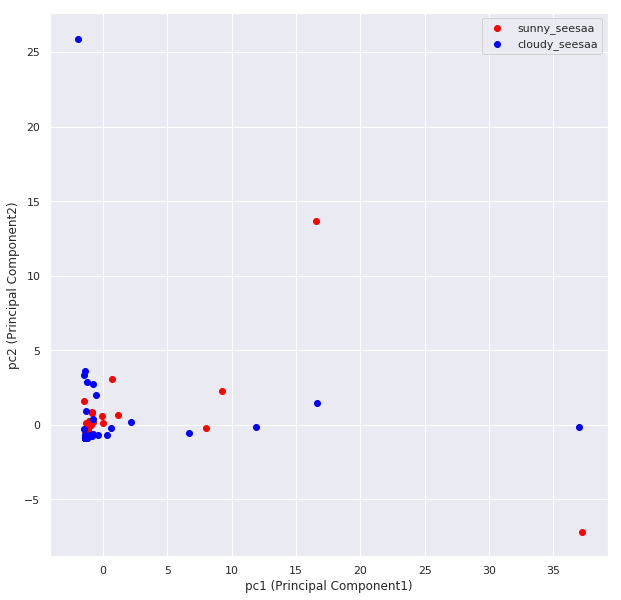

In [4]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

config = tf.ConfigProto(device_count={'GPU':1,'CPU':56})
sess = tf.Session(config=config)
keras.backend.set_session(sess)

STANDARD_SIZE = (300, 300)

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)

#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)                              
tf.set_random_seed(0)

input_shape = (300, 300, 3)
batch_size = 4
epochs = 10
num_classes = 2

f_log = './logs'
f_model = './model'


model_filename = 'cnn_model.json'
weights_filename = 'cnn_model_weights.hdf5'

def input_data(path_train, path_test):

    x = []

    with open(path_train, "r") as f:
        train_path_list = f.readlines()

    filenames = []
    labels = []
    for row in train_path_list:
        row = row.split(" ")
        filenames.append(row[0])
        labels.append(row[1])

    label = []
    for i in labels:
        label.append(int(i))

    for f in filenames:
        x.append(image.img_to_array(img_to_matrix(f)))

    x = np.asarray(x)
    #正規化                                                                                                                 
    x /= 255
    y = np.asarray(label)
    y = keras.utils.to_categorical(y, num_classes)

    '==============================================================='

    a = []
    
    with open(path_test, "r") as f:
        train_path_list = f.readlines()

    filenames1 = []
    labels1 = []
    for row in train_path_list:
        row = row.split(" ")
        filenames1.append(row[0])
        labels1.append(row[1])

    label1 = []
    for i in labels1:
        label1.append(int(i))

    for f in filenames1:
        a.append(image.img_to_array(img_to_matrix(f)))

    test_data = np.asarray(a)
    # 正規化                                                                                                                
    test_data /= 255
    test_label = np.asarray(label1)
    test_label = keras.utils.to_categorical(test_label, num_classes)

    train_data, valid_data, train_label, valid_label = cross_validation.train_test_split(x, y, test_size=0.3)
    test_data, valid1, test_label, valid2 = cross_validation.train_test_split(test_data, test_label, test_size=0.3)
    
    print(np.shape(train_data))
    print(np.shape(train_label))
    return train_data, test_data, train_label, test_label, valid_data, valid_label



# parse image                                                                                                               
def img_to_matrix(filename, verbose=False):
    img = Image.open(filename)
    if verbose:
        print('changing size from %s to %s' % (str(img.size), str(STANDARD_SIZE)))
    img = img.resize(STANDARD_SIZE)
    imgArray = np.asarray(img)
    return imgArray  # imgArray.shape = (167 x 300 x 3)                                                                     


# 1次元に引き延ばす(PCAで使用)                                                                                              
def flatten_image(img):

    s = img.shape[0] * img.shape[1] #* img.shape[2]
    img_wide = img.reshape(1, s)
    return img_wide[0]


def handle_image_with_pca(activations, y_test):

    for i in range(2):
        images = activations[i,:,:,:]
        print(images)
        if i == 0:
            labels = y_test[:64]
        elif i == 1:
            labels = y_test[64:]
        ls = []

        for label in labels:

            if list(label) == [0,1]:
                ls.append("cloudy_seesaa")
            elif list(label) == [1,0]:
                ls.append("sunny_seesaa")
        labels = ls
        print(labels)
        data = []
        for a in range(64):#for image in images:
            img = flatten_image(images[:, :, a])
            data.append(img)

        data = np.array(data)

        is_train = np.random.uniform(0, 1, len(data)) <= 0.7
        y = np.where(np.array(labels) == 'cloudy_seesaa', 1, 0)

        train_x, train_y = data[is_train], y[is_train]

        pca = PCA(n_components=2)
        X = pca.fit_transform(data)
        if i == 0:
            df1 = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                               "label": np.where(y == 1, 'cloudy_seesaa', 'sunny_seesaa')})
        elif i == 1:
            df2 = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                               "label": np.where(y == 1, 'cloudy_seesaa', 'sunny_seesaa')})
            df = pd.concat([df1, df2])
    colors = ['red','blue']

    plt.figure(figsize=(10, 10))
    for label, color in zip(df['label'].unique(), colors):
        mask = df['label'] == label
        plt.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)
    sns.set()
    plt.xlabel("pc1 (Principal Component1)")  # 全データの分散が最大となる方向                                              
    plt.ylabel("pc2 (Principal Component2)")  # 第一主成分に垂直な方向の軸                                                  
    plt.legend()
    #plt.show()                                                                                                             
    plt.savefig('pca_feature1.png')

    # training a classifier                                                                                                 
    pca = PCA(n_components=2)
    train_x = pca.fit_transform(train_x)
    """
    svm = LinearSVC(C=1.0)
    svm.fit(train_x, train_y)
    joblib.dump(svm, 'model.pkl')

    # evaluating the model                                                                                                  
    test_x, test_y = data[is_train == False], y[is_train == False]
    test_x = pca.transform(test_x)
    print(pd.crosstab(test_y, svm.predict(test_x),
                      rownames=['Actual'], colnames=['Predicted']))
    """
def main():

    x_train, x_test, y_train, y_test, valid_data, valid_label = input_data("path_and_label_train.txt",
                                                                           "path_and_label_test.txt")

    old_session = KTF.get_session()

    with tf.Graph().as_default():

        session = tf.Session('')
        KTF.set_session(session)
        KTF.set_learning_phase(1)
        """
        model = Sequential()                                                                                                
        model.add(Conv2D(32, kernel_size=(3, 3),                                                                            
                         activation='relu',                                                                                 
                         input_shape=input_shape, kernel_initializer="he_normal",                        
                         bias_initializer="zeros"))                                                                         
        model.add(Conv2D(64, (3, 3), activation='relu'))                                                                    
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))                                                                                            
        model.add(Flatten())                                                                                                
        model.add(Dense(28, activation='relu', init='he_uniform'))                                                          
        model.add(Dropout(0.5))                                                                                             
        model.add(Dense(num_classes, activation='softmax')) # num_classes = 2値分類                                         
                                                                                                                            
                                                                                                                            
        """
       # load trained model                                                                                                
        json_string = open(os.path.join(f_model, model_filename)).read()
        model = model_from_json(json_string)
        model.load_weights(os.path.join(f_model, weights_filename))
        """                                                                                                                 
        model.compile(loss=keras.losses.categorical_crossentropy,                                                           
                      optimizer="SGD",                                                                                      
                      metrics=['accuracy'])                                                                                 
                                                                                                                            
        print(model.summary())                                                                                              
                                                                                                                            
        # callback function                                                                                                 
        tb_cb = keras.callbacks.TensorBoard(log_dir=f_log, histogram_freq=1)                                                
        cbks = [tb_cb]                                                                                                      
                                                                                                                            
        # train                                                                                                             
        history = model.fit(x_train, y_train,                                                                               
                            batch_size=batch_size,                                                                          
                            epochs=epochs,                                                                                  
                            verbose=1,       #進行状況の表示モード                                                          
                            callbacks=cbks,  # [plot_losses, csv_logger],                                                   
                            validation_data=(x_test, y_test))                                                               
        score_train = model.evaluate(x_train,y_train, verbose=1, batch_size=4)                                              
        score_test = model.evaluate(x_test, y_test, verbose=1, batch_size=4)                                                
        print('Train loss: {0}'.format(score_train[0]))                                                                     
        print('Train accuracy: {0}'.format(score_train[1]))                                                                 
        print('Test loss: {0}'.format(score_test[0]))                                                                       
        print('Test accuracy: {0}'.format(score_test[1]))                                                                   
                                                                                                                            
        # 学習済みモデル書き出し                                                                                            
        json_string = model.to_json()                                                                                       
        open(os.path.join(f_model, 'cnn_model.json'), 'w').write(json_string)                                               
        yaml_string = model.to_yaml()                                                                                       
        open(os.path.join(f_model, 'cnn_model.yaml'), 'w').write(yaml_string)                                               
        print('save weights')                                                                                               
        model.save_weights(os.path.join(f_model, 'cnn_model_weights.hdf5'))                                                 
        """
       # modelのlayer_nameを調べる                                                                                                                         
        for layer in model.layers:
            print(layer.name)

        layer_name ="max_pooling2d_1"#"conv2d_2"# "max_pooling2d_1"                                                                                    
        intermediate_layer_model = keras.models.Model(inputs=model.input,
                                         outputs=model.get_layer(layer_name).output)


        layers = model.layers[2:3]     
        
        urls = ["/home/seimei/Graduation_Research/dataset_valid/hare/class3-1/image_0104.jpg", 
        "/home/seimei/Graduation_Research/dataset_valid/kumori/class4-5/image_0064.jpg"]

        activations = np.zeros((0,148,148,64))
        for url in urls:
            img = image.load_img(url, target_size=(300, 300))
            img = image.img_to_array(img)
            img /= 255
            img = np.expand_dims(img, axis=0)
            # 指定したlayer_nameと一致するレイヤーの出力を取得する                                                                                              
            _activations = intermediate_layer_model.predict(img)
            _activations = [activation for layer, activation in zip(layers, _activations) if isinstance(layer, MaxPooling2D)]
            print(np.shape(_activations))
            activations = np.r_[activations, np.reshape(_activations,(-1,148,148,64))]
        print(np.shape(activations))
        """
        # 単品の特徴画像生成#                                                                                                                               
        for i, activation in enumerate(activations):
            num_of_image = activation.shape[2]
            max = np.max(activation[0])
            for j in range(0, num_of_image):
                plt.figure(figsize=(50, 50))
                sns.heatmap(activation[:, :,j], vmin=0, vmax=max, xticklabels=False, yticklabels=False, square=False)
                plt.savefig("%d_%d.png" % (i+1, j+1))
                plt.close()
        # 出力層ごとに特徴画像を並べてヒートマップ画像として出力                                                                                            
        for i, activation in enumerate(activations):
            num_of_image = activation.shape[2]
            cols = math.ceil(math.sqrt(num_of_image))
            rows = math.floor(num_of_image / cols)
            screen = []
            for y in range(0, rows):
                row = []
                for x in range(0, cols):
                    j = y * cols + x
                    if j < num_of_image:
                        row.append(activation[:, :, j])
                    else:
                        row.append(np.zeros())
                screen.append(np.concatenate(row, axis=1))
            screen = np.concatenate(screen, axis=0)
            plt.figure(figsize=(50, 50))
            sns.heatmap(screen, xticklabels=False, yticklabels=False)
            name = "maxpooling2d"
            plt.savefig("%s.png" % name)
            plt.close()
        """
        y = keras.utils.to_categorical(np.r_[np.zeros(64), np.ones(64)], num_classes)

        handle_image_with_pca(activations, y )
        



    # add for TeonsorBoard                                                                                                                                  

    KTF.set_session(old_session)

if __name__ == '__main__':
    main()

# DropOut

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

config = tf.ConfigProto(device_count={'GPU':1,'CPU':56})
sess = tf.Session(config=config)
keras.backend.set_session(sess)

STANDARD_SIZE = (300, 300)

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)

#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)                              
tf.set_random_seed(0)

input_shape = (300, 300, 3)
batch_size = 4
epochs = 10
num_classes = 2

f_log = './logs'
f_model = './model'


model_filename = 'cnn_model.json'
weights_filename = 'cnn_model_weights.hdf5'

def input_data(path_train, path_test):

    x = []

    with open(path_train, "r") as f:
        train_path_list = f.readlines()

    filenames = []
    labels = []
    for row in train_path_list:
        row = row.split(" ")
        filenames.append(row[0])
        labels.append(row[1])

    label = []
    for i in labels:
        label.append(int(i))

    for f in filenames:
        x.append(image.img_to_array(img_to_matrix(f)))

    x = np.asarray(x)
    #正規化                                                                                                                 
    x /= 255
    y = np.asarray(label)
    y = keras.utils.to_categorical(y, num_classes)

    '==============================================================='

    a = []
    
    with open(path_test, "r") as f:
        train_path_list = f.readlines()

    filenames1 = []
    labels1 = []
    for row in train_path_list:
        row = row.split(" ")
        filenames1.append(row[0])
        labels1.append(row[1])

    label1 = []
    for i in labels1:
        label1.append(int(i))

    for f in filenames1:
        a.append(image.img_to_array(img_to_matrix(f)))

    test_data = np.asarray(a)
    # 正規化                                                                                                                
    test_data /= 255
    test_label = np.asarray(label1)
    test_label = keras.utils.to_categorical(test_label, num_classes)

    train_data, valid_data, train_label, valid_label = cross_validation.train_test_split(x, y, test_size=0.3)
    test_data, valid1, test_label, valid2 = cross_validation.train_test_split(test_data, test_label, test_size=0.3)
    
    print(np.shape(train_data))
    print(np.shape(train_label))
    return train_data, test_data, train_label, test_label, valid_data, valid_label



# parse image                                                                                                               
def img_to_matrix(filename, verbose=False):
    img = Image.open(filename)
    if verbose:
        print('changing size from %s to %s' % (str(img.size), str(STANDARD_SIZE)))
    img = img.resize(STANDARD_SIZE)
    imgArray = np.asarray(img)
    return imgArray  # imgArray.shape = (167 x 300 x 3)                                                                     


# 1次元に引き延ばす(PCAで使用)                                                                                              
def flatten_image(img):

    s = img.shape[0] * img.shape[1] #* img.shape[2]
    img_wide = img.reshape(1, s)
    return img_wide[0]


def handle_image_with_pca(activations, y_test):

    for i in range(2):
        images = activations[i,:,:,:]
        print(images)
        if i == 0:
            labels = y_test[:64]
        elif i == 1:
            labels = y_test[64:]
        ls = []

        for label in labels:

            if list(label) == [0,1]:
                ls.append("cloudy_seesaa")
            elif list(label) == [1,0]:
                ls.append("sunny_seesaa")
        labels = ls
        print(labels)
        data = []
        for a in range(64):#for image in images:
            img = flatten_image(images[:, :, a])
            data.append(img)

        data = np.array(data)

        is_train = np.random.uniform(0, 1, len(data)) <= 0.7
        y = np.where(np.array(labels) == 'cloudy_seesaa', 1, 0)

        train_x, train_y = data[is_train], y[is_train]

        pca = RandomizedPCA(n_components=2)
        X = pca.fit_transform(data)
        if i == 0:
            df1 = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                               "label": np.where(y == 1, 'cloudy_seesaa', 'sunny_seesaa')})
        elif i == 1:
            df2 = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                               "label": np.where(y == 1, 'cloudy_seesaa', 'sunny_seesaa')})
            df = pd.concat([df1, df2])
    colors = ['red','blue']

    plt.figure(figsize=(10, 10))
    for label, color in zip(df['label'].unique(), colors):
        mask = df['label'] == label
        plt.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)
    sns.set()
    plt.xlabel("pc1 (Principal Component1)")  # 全データの分散が最大となる方向                                              
    plt.ylabel("pc2 (Principal Component2)")  # 第一主成分に垂直な方向の軸                                                  
    plt.legend()
    #plt.show()                                                                                                             
    plt.savefig('pca_feature1.png')

    # training a classifier                                                                                                 
    pca = RandomizedPCA(n_components=2)
    train_x = pca.fit_transform(train_x)
    """
    svm = LinearSVC(C=1.0)
    svm.fit(train_x, train_y)
    joblib.dump(svm, 'model.pkl')

    # evaluating the model                                                                                                  
    test_x, test_y = data[is_train == False], y[is_train == False]
    test_x = pca.transform(test_x)
    print(pd.crosstab(test_y, svm.predict(test_x),
                      rownames=['Actual'], colnames=['Predicted']))
    """
def main():

    x_train, x_test, y_train, y_test, valid_data, valid_label = input_data("path_and_label_train.txt",
                                                                           "path_and_label_test.txt")

    old_session = KTF.get_session()

    with tf.Graph().as_default():

        session = tf.Session('')
        KTF.set_session(session)
        KTF.set_learning_phase(1)
        """
        model = Sequential()                                                                                                
        model.add(Conv2D(32, kernel_size=(3, 3),                                                                            
                         activation='relu',                                                                                 
                         input_shape=input_shape, kernel_initializer="he_normal",                        
                         bias_initializer="zeros"))                                                                         
        model.add(Conv2D(64, (3, 3), activation='relu'))                                                                    
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))                                                                                            
        model.add(Flatten())                                                                                                
        model.add(Dense(28, activation='relu', init='he_uniform'))                                                          
        model.add(Dropout(0.5))                                                                                             
        model.add(Dense(num_classes, activation='softmax')) # num_classes = 2値分類                                         
                                                                                                                            
                                                                                                                            
        """
       # load trained model                                                                                                
        json_string = open(os.path.join(f_model, model_filename)).read()
        model = model_from_json(json_string)
        model.load_weights(os.path.join(f_model, weights_filename))
        """                                                                                                                 
        model.compile(loss=keras.losses.categorical_crossentropy,                                                           
                      optimizer="SGD",                                                                                      
                      metrics=['accuracy'])                                                                                 
                                                                                                                            
        print(model.summary())                                                                                              
                                                                                                                            
        # callback function                                                                                                 
        tb_cb = keras.callbacks.TensorBoard(log_dir=f_log, histogram_freq=1)                                                
        cbks = [tb_cb]                                                                                                      
                                                                                                                            
        # train                                                                                                             
        history = model.fit(x_train, y_train,                                                                               
                            batch_size=batch_size,                                                                          
                            epochs=epochs,                                                                                  
                            verbose=1,       #進行状況の表示モード                                                          
                            callbacks=cbks,  # [plot_losses, csv_logger],                                                   
                            validation_data=(x_test, y_test))                                                               
        score_train = model.evaluate(x_train,y_train, verbose=1, batch_size=4)                                              
        score_test = model.evaluate(x_test, y_test, verbose=1, batch_size=4)                                                
        print('Train loss: {0}'.format(score_train[0]))                                                                     
        print('Train accuracy: {0}'.format(score_train[1]))                                                                 
        print('Test loss: {0}'.format(score_test[0]))                                                                       
        print('Test accuracy: {0}'.format(score_test[1]))                                                                   
                                                                                                                            
        # 学習済みモデル書き出し                                                                                            
        json_string = model.to_json()                                                                                       
        open(os.path.join(f_model, 'cnn_model.json'), 'w').write(json_string)                                               
        yaml_string = model.to_yaml()                                                                                       
        open(os.path.join(f_model, 'cnn_model.yaml'), 'w').write(yaml_string)                                               
        print('save weights')                                                                                               
        model.save_weights(os.path.join(f_model, 'cnn_model_weights.hdf5'))                                                 
        """
       # modelのlayer_nameを調べる                                                                                                                         
        for layer in model.layers:
            print(layer.name)

        layer_name ="dropout_1"#"conv2d_2"# "max_pooling2d_1"                                                                                    
        intermediate_layer_model = keras.models.Model(inputs=model.input,
                                         outputs=model.get_layer(layer_name).output)


        layers = model.layers[3:4]     
        
        urls = ["/home/seimei/Graduation_Research/dataset_valid/hare/class3-1/image_0104.jpg", 
        "/home/seimei/Graduation_Research/dataset_valid/kumori/class4-5/image_0064.jpg"]

        activations = np.zeros((0,148,148,64))
        for url in urls:
            img = image.load_img(url, target_size=(300, 300))
            img = image.img_to_array(img)
            img /= 255
            img = np.expand_dims(img, axis=0)
            # 指定したlayer_nameと一致するレイヤーの出力を取得する                                                                                              
            _activations = intermediate_layer_model.predict(img)
            _activations = [activation for layer, activation in zip(layers, _activations) if isinstance(layer, Dropout)]
            print(np.shape(_activations))
            activations = np.r_[activations, np.reshape(_activations,(-1,148,148,64))]
        print(np.shape(activations))
        """
        # 単品の特徴画像生成#                                                                                                                               
        for i, activation in enumerate(activations):
            num_of_image = activation.shape[2]
            max = np.max(activation[0])
            for j in range(0, num_of_image):
                plt.figure(figsize=(50, 50))
                sns.heatmap(activation[:, :,j], vmin=0, vmax=max, xticklabels=False, yticklabels=False, square=False)
                plt.savefig("%d_%d.png" % (i+1, j+1))
                plt.close()
        # 出力層ごとに特徴画像を並べてヒートマップ画像として出力                                                                                            
        for i, activation in enumerate(activations):
            num_of_image = activation.shape[2]
            cols = math.ceil(math.sqrt(num_of_image))
            rows = math.floor(num_of_image / cols)
            screen = []
            for y in range(0, rows):
                row = []
                for x in range(0, cols):
                    j = y * cols + x
                    if j < num_of_image:
                        row.append(activation[:, :, j])
                    else:
                        row.append(np.zeros())
                screen.append(np.concatenate(row, axis=1))
            screen = np.concatenate(screen, axis=0)
            plt.figure(figsize=(50, 50))
            sns.heatmap(screen, xticklabels=False, yticklabels=False)
            name = "maxpooling2d"
            plt.savefig("%s.png" % name)
            plt.close()
        """
        y = keras.utils.to_categorical(np.r_[np.zeros(64), np.ones(64)], num_classes)

        handle_image_with_pca(activations, y )
        



    # add for TeonsorBoard                                                                                                                                  

    KTF.set_session(old_session)

if __name__ == '__main__':
    main()